In [139]:
import datetime

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
import matplotlib.pyplot as plt
from scipy import stats
#yfin.pdr_override() #we need this to get data from Yahoo!Finance
#from pandas_datareader.famafrench import get_available_datasets

In [ ]:
# SECURITIES
# scenario 1: loan for a credit card (unsecured)
# scenario 2: loan for a house in California (collateral is the house)
# scenario 3: loan to a construction company (collateral is the building under construction, but not the land)
# scenario 4: snp500 index
# scenario 5: treasury bond (e.g. 30y)
# scenario 6: illiquid corporate bond of high quality company (choose a company)

In [ ]:
# DATASETS
# scenario 1: delinquency rates on credit cards https://fred.stlouisfed.org/series/DRCCLACBS
# scenario 2: average 30y mortgage rate https://fred.stlouisfed.org/series/MORTGAGE30US 
# and mortgage delinquency rate https://fred.stlouisfed.org/series/DRSFRMACBS
# and house price index for California https://fred.stlouisfed.org/series/CASTHPI
# scenario 3: building material prices https://fred.stlouisfed.org/series/PCU44414441
# scenario 4: publicly traded equity: snp500 (fred)
# scenario 5: treasury bond 30y yield (get from Yahoo?)
# scenario 6: https://fred.stlouisfed.org/series/DAAA <- proxy for high quality illiquid bond (fred)

In [ ]:
# IDEA
# WE NEED TO BUY A TREASURY BOND TO LEND IN SCENARIO 5. IT WILL BE RETURNED TO US LATER. IN THE MEANTIME ITS PRICE MOVED.
# IF ITS PRICE WENT DOWN (YIELD GOES UP), WE WILL LOSE MONEY. ON THE OTHER HAND, IF YIELD GOES UP, INTEREST RATES GO UP,
# AND SO LIKELY DELINQUENCY RATES ON CREDIT CARDS WILL GO UP (WE NEED TO PROVE THIS WITH A SCATTER PLOT AND CORRELATION VALUE).
# BUT THIS ALSO MEANS WE WILL HAVE HIGHER CREDIT RISK IN SCENARIO 1. AT THE SAME TIME, AS RATES RISE, MORTGAGE DELINQUENCY RATES
# MIGHT GO UP AND HOUSE PRICES DROP, WHICH MAKES THE COLLATERAL IN SCENARIO 2 GO DOWN AND CREDIT RISK GO UP. SO THE PROBLEMS ARE SNOWBALLING.
# IN SCENARIO 6 WE ARE LESS WORRIED BECAUSE DUE TO THE ILLIQUID NATURE OF THE BOND, WE WILL LIKELY CHOOSE NOT LIQUIDATE IT AND TO WAIT
# UNTIL ITS MATURITY AND COLLECT THE COUPONS. IN SCENARIO 4, SNP500 INDEX MIGHT GO DOWN WITH INTEREST RATES (TO BE CHECKED), AND IT
# WOULD BE INTERESTING TO ANALYSE ITS DISTRIBUTION OF RETURNS WITH A HISTORGRAM AND HOW FAR IT IS FROM A NORMAL DISTRIBUTION (CALCULATE SKEW AND KURT).
# I'M NOT SURE ABOUT SCENARIO 3, BUT I WAS THINKING THAT BUILDING MATERIALS GOING UP IN PRICE IS BAD AS IT IS LESS LIKELY THE
# CONSTRUCTION COMPANY WILL SUCCESSFULLY FINISH THE BUILDING.


In [151]:
# Renaming the data for easier interpretation, with data frequency
column_name_mapping = {
    'DRCCLACBS': 'CreditCardDelinq (quarterly)', 
    'MORTGAGE30US': 'AvgMortgageRate (weekly)',
    'DRSFRMACBS': 'MortgageDelinq (quarterly)',
    'CASTHPI': 'HousePxIdx_CA (quarterly)',
    'PCU44414441': 'BuildingMaterialPx (monthly)',
    'sp500': 'SP500 (daily)',
    'DAAA': 'InvestmentBondYield (daily)'
}

In [152]:
end = datetime.date.today() #coded on 09/Jan/2024
start = end - datetime.timedelta(365 * 10)
df = web.DataReader(['DRCCLACBS', 'MORTGAGE30US', 'DRSFRMACBS', 'CASTHPI', 'PCU44414441', 'sp500', 'DAAA'], 'fred', start, end)
df.rename(columns=column_name_mapping, inplace=True)
df.head()

,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly),BuildingMaterialPx (monthly),SP500 (daily),InvestmentBondYield (daily)
DATE,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47


## Plot all the time series for visualisation

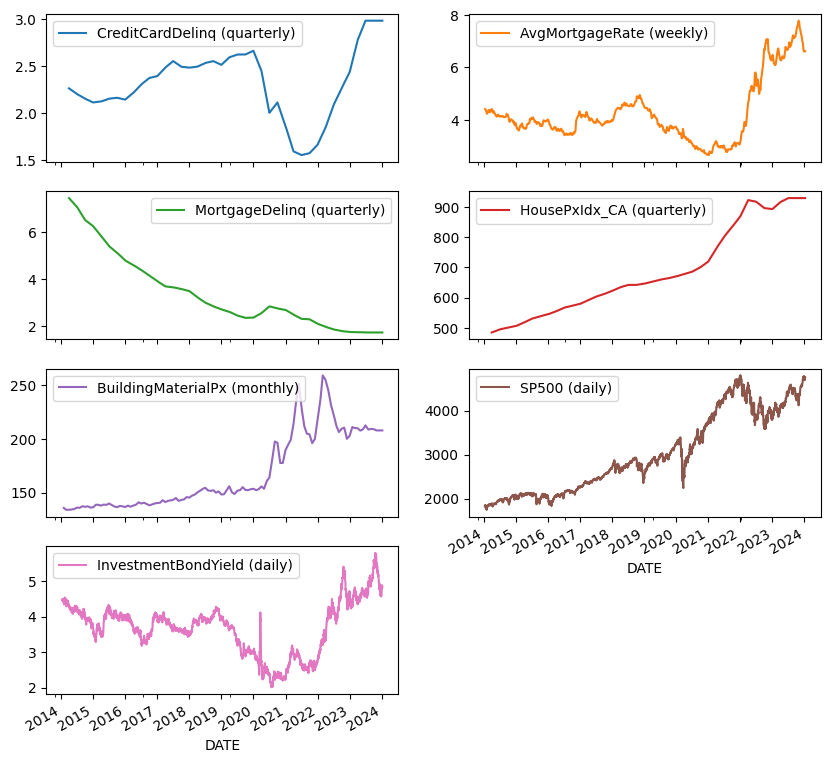

In [153]:
#interpolate on the dates just for plotting
df_interpolated = df.interpolate('index')
df_interpolated.plot(subplots=True, layout=(4,2), figsize=(10,10));

In [154]:
# The below columns have date indices on the first of the month, which may not be a business day.
# We bump their index to the next business day to better align their valid dates to those of other series (e.g. sp500).
for feature in ['BuildingMaterialPx (monthly)', 'HousePxIdx_CA (quarterly)', 'MortgageDelinq (quarterly)', 'CreditCardDelinq (quarterly)']:
    clean_series = df[feature].dropna()
    df[feature] = pd.Series(clean_series.values, index=[d + BDay(0) for d in clean_series.index])

In [155]:
df.head()

,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly),BuildingMaterialPx (monthly),SP500 (daily),InvestmentBondYield (daily)
DATE,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47


## Calculate returns
Care must be taken as different features have returns in different time horizons. So we calculate returns for each time granuarity in our dataset.

We avoid casting low-frequency data into higher frequency (e.g. quarterly to daily) because this would be too crude.

In [179]:
def calculate_returns(df):
    df_returns = np.log(df)-np.log(df.shift(1))
    return df_returns.dropna()

# drop mortgage rate as its indices do not align with the quarterly data
df_quarterly = df.drop(columns='AvgMortgageRate (weekly)').loc[df['CreditCardDelinq (quarterly)'].dropna().index].ffill()
df_monthly = df.loc[df['BuildingMaterialPx (monthly)'].dropna().index, 
                                                             ['SP500 (daily)','InvestmentBondYield (daily)', 'BuildingMaterialPx (monthly)']].ffill()
df_weekly = df.loc[df['AvgMortgageRate (weekly)'].dropna().index, 
                   ['AvgMortgageRate (weekly)','SP500 (daily)','InvestmentBondYield (daily)']].ffill()
df_daily = df.loc[df['SP500 (daily)'].dropna().index, ['SP500 (daily)','InvestmentBondYield (daily)']].ffill()

df_quarterly_returns = calculate_returns(df_quarterly)
df_monthly_returns = calculate_returns(df_monthly)
df_weekly_returns = calculate_returns(df_weekly)
df_daily_returns = calculate_returns(df_daily)
df_daily_returns.head()

,SP500 (daily),InvestmentBondYield (daily)
DATE,,
2014-01-14,0.010760,0.006689
2014-01-15,0.005153,0.000000
2014-01-16,-0.001348,-0.004454
2014-01-17,-0.003903,-0.002235
2014-01-21,0.002770,-0.002240


In [180]:
print('Skew')
print(df_daily_returns.skew().rename('skew'))
print('\nExcess Kurtosis')
print(df_daily_returns.kurt().rename('kurtosis'))

Skew
SP500 (daily)                 -0.808339
InvestmentBondYield (daily)    0.622136
Name: skew, dtype: float64

Excess Kurtosis
SP500 (daily)                  16.062571
InvestmentBondYield (daily)    13.271384
Name: kurtosis, dtype: float64


## Plot a heatmap of the correlation matrix of log-returns.
The correlations for quarterly data would no be reliable as we have no more than 40 datapoints to calculate it. Even going from weekly to daily data can have considerable impact. In fact, notice that the correlation beween the snp500 and bond yields is negative for weekly data but positive for daily data. The comparison between monthly and daily data is even more striking as the correlation goes from strong negative to small positive.

Building material prices are somewhat positively correlated to sp500 returns and bond yields, which may be explained by inflation (notice that higher inflation pushes the nominal interest rates higher).

Average mortgage rates are positively correlated with bond yields, which is intuitive since higher interest rates translates into higher mortgage rates. Mortgage rates are negatively correlated with sp500 returns, implying that more money is being spent in repaying loans than in equity investment.

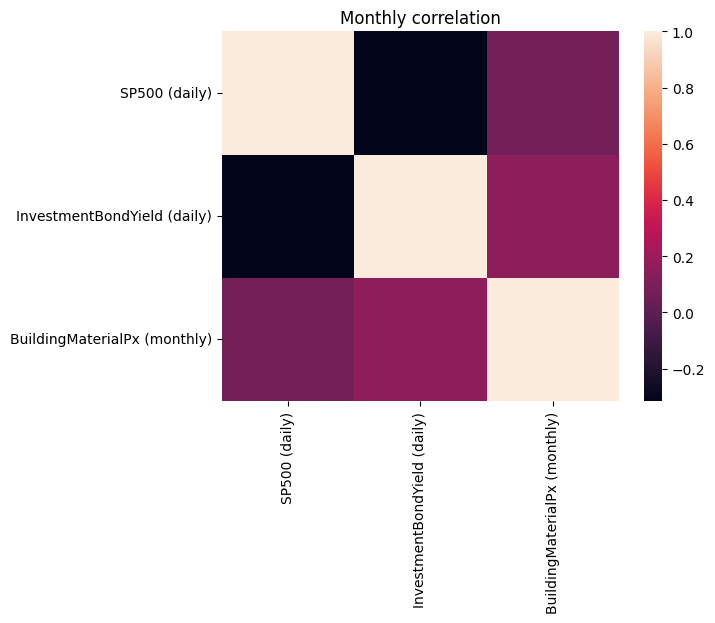

<Figure size 500x500 with 0 Axes>

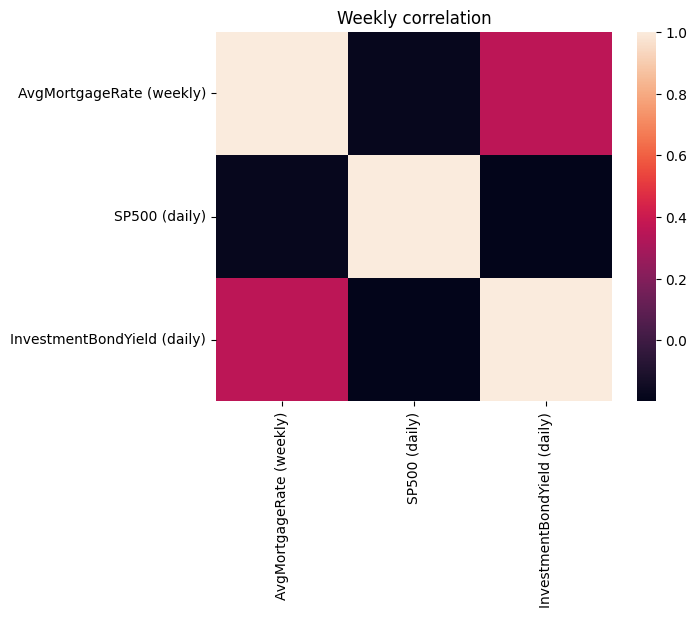

<Figure size 500x500 with 0 Axes>

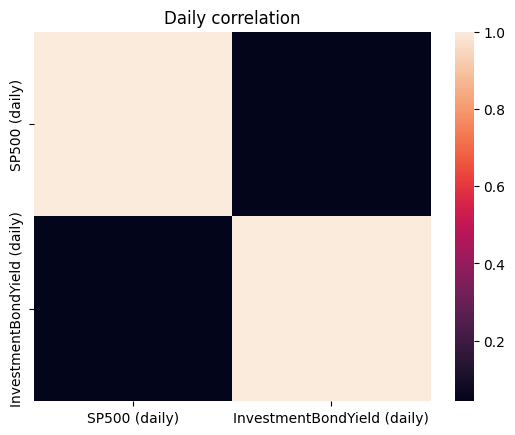

<Figure size 500x500 with 0 Axes>

In [189]:
def plot_correlation_heatmap(df_ret, title):
    corr_matrix = df_ret.corr().round(3)
    sns.heatmap(corr_matrix)
    plt.title(title)
    plt.figure(figsize=(5,5))
    plt.show();
plot_correlation_heatmap(df_monthly_returns, 'Monthly correlation')
plot_correlation_heatmap(df_weekly_returns, 'Weekly correlation')
plot_correlation_heatmap(df_daily_returns, 'Daily correlation')

In [ ]:
# chart = sns.regplot(x="SP500", y="NASDAQ", data=df).set(
#     title="Figure 3: Daily S&P 500 Returns vs NASDAQ Returns"
# )

# plt.axvline(0, 0, 1, dash_capstyle="butt", linestyle="--", color="grey")
# plt.plot([min(df.SP500), max(df.SP500)], [0, 0], linestyle="--", color="grey");